In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [29]:
_image_dir = '../datasets/celeba/img_align_celeba_png/'
_img_width = 178
_img_height = 218
_batch_size = 16
_num_epochs = 20

In [30]:
img_df = pd.read_csv('../datasets/celeba/attributes/attr_celeba.csv').replace({-1:0})[['filename', 'Eyeglasses', 'Smiling', 'Male', 'No_Beard', 'Young']]
partition_df = pd.read_csv('../datasets/celeba/attributes/list_eval_partition.csv')
img_df = img_df.merge(partition_df, on='filename')
img_df.loc[:, 'filename'] = img_df.loc[:, 'filename'].apply(lambda x: os.path.join(_image_dir, x))
img_df.head()

,filename,Eyeglasses,Smiling,Male,No_Beard,Young,partition
0,../datasets/celeba/img_align_celeba_png/000001...,0,1,0,1,1,0
1,../datasets/celeba/img_align_celeba_png/000002...,0,1,0,1,1,0
2,../datasets/celeba/img_align_celeba_png/000003...,0,0,1,1,1,0
3,../datasets/celeba/img_align_celeba_png/000004...,0,0,0,1,1,0
4,../datasets/celeba/img_align_celeba_png/000005...,0,0,0,1,1,0


In [31]:
train_df = img_df.loc[img_df.loc[:, 'partition'] == 0, ['filename', 'Eyeglasses', 'Smiling', 'Male', 'No_Beard', 'Young']]
valid_df = img_df.loc[img_df.loc[:, 'partition'] == 1, ['filename', 'Eyeglasses', 'Smiling', 'Male', 'No_Beard', 'Young']]
test_df = img_df.loc[img_df.loc[:, 'partition'] == 2, ['filename', 'Eyeglasses', 'Smiling', 'Male', 'No_Beard', 'Young',]]

In [32]:
train_datagen =  ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     brightness_range=[0.4,1.5],
    preprocessing_function=preprocess_input,
    rescale=1./255,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    batch_size=_batch_size,
    x_col='filename', 
    y_col= ['Eyeglasses', 'Smiling', 'Male', 'No_Beard', 'Young'],
    class_mode='raw',
    target_size=(_img_width, _img_height),
    validate_filenames=False)

Found 162770 non-validated image filenames.


In [33]:
valid_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    batch_size=_batch_size,
    x_col='filename', 
    y_col=['Eyeglasses', 'Smiling', 'Male', 'No_Beard', 'Young'],
    class_mode='raw',
    target_size=(_img_width, _img_height),
    validate_filenames=False)

Found 19867 non-validated image filenames.


In [34]:
base_model = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(_img_width, _img_height, 3))

print("number of layers:", len(base_model.layers))

for layer in base_model.layers:
    layer.trainable = False

number of layers: 311


In [35]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(5, activation="sigmoid")(x)

In [36]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
checkpointer = ModelCheckpoint(filepath='inception_v3_eyeglasses_smiling_male_nobeard_young.h5', verbose=1, save_best_only=True)

In [ ]:
hist = model.fit_generator(train_generator,
                            validation_data = valid_generator,
                            steps_per_epoch= len(train_df)//_batch_size,
                            validation_steps=len(valid_df) // _batch_size,
                            epochs=_num_epochs,
                            callbacks=[checkpointer],
                            verbose=1,
                           )

Epoch 1/20
10173/10173 [==============================] - 461s 45ms/step - loss: 0.3680 - accuracy: 0.8306 - val_loss: 0.6186 - val_accuracy: 0.6980

Epoch 00001: val_loss improved from inf to 0.61862, saving model to inception_v3_eyeglasses_smiling_male_nobeard_young.h5
Epoch 2/20
10173/10173 [==============================] - 459s 45ms/step - loss: 0.3478 - accuracy: 0.8418 - val_loss: 0.5421 - val_accuracy: 0.6953

Epoch 00002: val_loss improved from 0.61862 to 0.54207, saving model to inception_v3_eyeglasses_smiling_male_nobeard_young.h5
Epoch 3/20
10173/10173 [==============================] - 457s 45ms/step - loss: 0.3425 - accuracy: 0.8446 - val_loss: 0.5049 - val_accuracy: 0.7009

Epoch 00003: val_loss improved from 0.54207 to 0.50487, saving model to inception_v3_eyeglasses_smiling_male_nobeard_young.h5
Epoch 4/20
10173/10173 [==============================] - 457s 45ms/step - loss: 0.3392 - accuracy: 0.8459 - val_loss: 0.5046 - val_accuracy: 0.7115

Epoch 00004: val_loss impr

In [24]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

NameError: name 'hist' is not defined

<Figure size 1296x288 with 0 Axes>

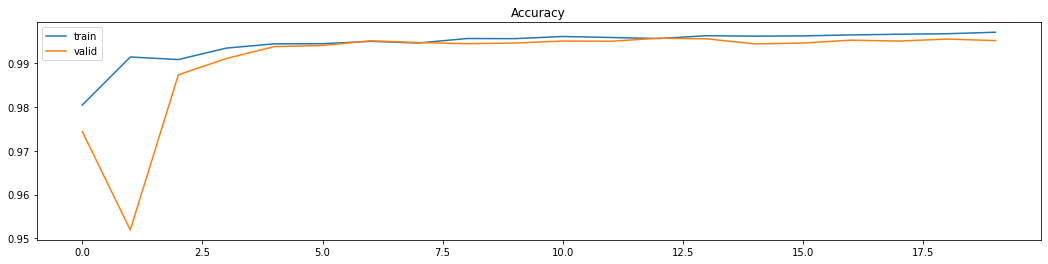

In [64]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [27]:
test_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    batch_size=1,
    x_col='filename', 
    y_col=['Eyeglasses', 'Smiling', 'Male', 'No_Beard', 'Young'],
    class_mode='raw',
    target_size=(_img_width, _img_height),
    validate_filenames=False,
    shuffle=False)

Found 19962 non-validated image filenames.


In [ ]:
model.load_weights('inception_v3_eyeglasses_smiling_male_nobeard_young.h5')
model_predictions = model.predict(test_generator)

In [67]:
preds = np.array(model_predictions > 0.5).astype(int)

In [68]:
test_accuracy = 100 * accuracy_score(preds, test_df.loc[:, ['Eyeglasses']].values)
test_accuracy

99.63931469792607

In [69]:
f1 = f1_score(test_df.loc[:,  ['Eyeglasses']].values, preds)
f1

0.9718530101641909